In [1]:
#!git clone https://github.com/anudeep23/CS7643-Final-Project-VOGN

In [2]:
#%cd /content/CS7643-Final-Project-VOGN

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## datasets.py

In [4]:
import numpy as np
import torch
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
DEFAULT_DATA_FOLDER = './data'

class Dataset():
    def __init__(self, data_set, data_folder = DEFAULT_DATA_FOLDER):
        super(type(self), self).__init__()

        if data_set == 'binary':
            X1 = torch.randn(1000, 50)
            X2 = torch.randn(1000, 50) + 1.5
            X = torch.cat([X1, X2], dim=0)
            Y1 = torch.zeros(1000, 1)
            Y2 = torch.ones(1000, 1)
            Y = torch.cat([Y1, Y2], dim=0)
            self.train_set = TensorDataset(X, Y)
            self.test_set = TensorDataset(X, Y)

        if data_set == 'mnist':
            #self.composed_transforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
            self.train_set = dset.MNIST(root=data_folder,
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

            self.test_set = dset.MNIST(root=data_folder,
                                       train=False,
                                       transform=transforms.ToTensor())

        if data_set == 'cifar10':

            #print(type(self.composed_transforms))
            train_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
            self.train_set = dset.CIFAR10(root=data_folder,
                                          train=True,
                                          transform= train_transform,
                                          download=True)

            self.test_set = dset.CIFAR10(root=data_folder,
                                         train=False,
                                         transform= test_transform)


    def get_train_size(self):
        return len(self.train_set)

    def get_test_size(self):
        return len(self.test_set)

    def get_train_loader(self, batch_size, shuffle=True):
        train_loader = DataLoader(dataset= self.train_set, batch_size=batch_size, shuffle=shuffle, num_workers=8)
        return train_loader

    def get_test_loader(self, batch_size, shuffle=False):
        test_loader = DataLoader(dataset= self.test_set, batch_size=batch_size, shuffle=shuffle, num_workers=8)
        return test_loader

    def load_full_train_set(self, use_cuda=torch.cuda.is_available()):

        full_train_loader = DataLoader(dataset = self.train_set,
                                       batch_size = len(self.train_set),
                                       shuffle = False)

        x_train, y_train = next(iter(full_train_loader))

        if use_cuda:
            x_train, y_train = x_train.cuda(), y_train.cuda()

        return x_train, y_train

    def load_full_test_set(self, use_cuda=torch.cuda.is_available()):

        full_test_loader = DataLoader(dataset = self.test_set,
                                      batch_size = len(self.test_set),
                                      shuffle = False)

        x_test, y_test = next(iter(full_test_loader))

        if use_cuda:
            x_test, y_test = x_test.cuda(), y_test.cuda()

        return x_test, y_test

## models.py

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

##################################
## Simple Convolutional Network ##
##################################
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0
        # print(input.shape)
        return F.linear(input, weight, bias)

class SimpleConvNet(nn.Module):
    def __init__(self, input_channels, dims = 32, num_classes=10):
        super(type(self), self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 6, kernel_size=5, stride=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        dims = int((dims - 4)/2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        dims = int((dims - 4) / 2)
        self.fc = nn.Linear(16*dims*dims, num_classes)

    def forward(self, x, sample=False, calculate_log_probs=False):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

###############
## LeNet - 5 ##
###############

class LeNet5(nn.Module):
    def __init__(self, input_channels, dims = 32, num_classes=10):
        super(type(self), self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        dims = int((dims-4)/2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        dims = int((dims-4)/2)
        self.fc1 = nn.Linear(16*dims*dims, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc(out)
        return out

############################
## Multi-Layer Perceptron ##
############################

class MLP(nn.Module):
    def __init__(self):
        super(type(self), self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 1200)
        self.fc3 = nn.Linear(1200, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## VOGN.py

In [6]:
import math
import torch
from torch.optim.optimizer import Optimizer
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torch.nn as nn
import torch.nn.functional as F

#TODO Refactor gradient scaling

################################
## PyTorch Optimizer for VOGN ##
################################
required = object()


def update_input(self, input, output):
    self.input = input[0].data
    self.output = output


class VOGN(Optimizer):
    """Implements the VOGN algorithm. It uses the Generalized Gauss Newton (GGN)
        approximation to the Hessian and a mean-field approximation. Note that this
        optimizer does **not** support multiple model parameter groups. All model
        parameters must use the same optimizer parameters.
        model (nn.Module): network model
        train_set_size (int): number of data points in the full training set
            (objective assumed to be on the form (1/M)*sum(-log p))
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running average of gradients and sum of squared gradient (default: 0.999)
        prior_mu (FloatTensor, optional): mu of prior distribution (posterior of previous task)
            (default: None)
        prior_prec (float or FloatTensor, optional): prior precision on parameters
            (default: 1.0)
        prec_init (float, optional): initial precision for variational dist. q
            (default: 1.0)
        num_samples (float, optional): number of MC samples
            (default: 1)
    """

    def __init__(self, model, train_set_size, lr=1e-3, betas=(0.9, 0.999), prior_mu=None, prior_prec=1.0,
                 initial_prec=1.0, num_samples=1):
        if lr <= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if prior_mu is not None and not torch.is_tensor(prior_mu):
            raise ValueError("Invalid prior mu value (from previous task): {}".format(prior_mu))
        if torch.is_tensor(prior_prec):
            if (prior_prec < 0.0).all():
                raise ValueError("Invalid prior precision tensor: {}".format(prior_prec))
        else:
            if prior_prec < 0.0:
                raise ValueError("Invalid prior precision value: {}".format(prior_prec))
        if torch.is_tensor(initial_prec):
            if (initial_prec < 0.0).all():
                raise ValueError("Invalid initial precision tensor: {}".format(initial_prec))
        else:
            if initial_prec < 0.0:
                raise ValueError("Invalid initial precision value: {}".format(initial_prec))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if num_samples < 1:
            raise ValueError("Invalid num_samples parameter: {}".format(num_samples))
        if train_set_size < 1:
            raise ValueError("Invalid number of training data points: {}".format(train_set_size))

        defaults = dict(lr=lr, betas=betas, prior_mu=prior_mu, prior_prec=prior_prec, initial_prec=initial_prec,
                        num_samples=num_samples, train_set_size=train_set_size)
        super(VOGN, self).__init__(model.parameters(), defaults)

        self.train_modules = []
        self.set_train_modules(model)
        for module in self.train_modules:
            module.register_forward_hook(update_input)

        defaults = self.defaults
        # We only support a single parameter group.
        parameters = self.param_groups[0]['params']
        device = parameters[0].device

        p = parameters_to_vector(parameters)
        # mean parameter of variational distribution.
        self.state['mu'] = p.clone().detach()

        # mean parameter of prior distribution.
        if torch.is_tensor(defaults['prior_mu']):
            self.state['prior_mu'] = defaults['prior_mu'].to(device)
        else:
            self.state['prior_mu'] = torch.zeros_like(p, device=device)

        # covariance parameter of variational distribution -- saved as a diagonal precision matrix.
        if torch.is_tensor(defaults['initial_prec']):
            self.state['precision'] = defaults['initial_prec'].to(device)
        else:
            self.state['precision'] = torch.ones_like(p, device=device) * defaults['initial_prec']

        # covariance parameter of prior distribution -- saved as a diagonal precision matrix.
        if torch.is_tensor(defaults['prior_prec']):
            self.state['prior_prec'] = defaults['prior_prec'].to(device)
        else:
            self.state['prior_prec'] = torch.ones_like(p, device=device) * defaults['prior_prec']

        self.state['momentum'] = torch.zeros_like(p, device=device)

    def set_train_modules(self, module):
        if len(list(module.children())) == 0:
            if len(list(module.parameters())) != 0:
                self.train_modules.append(module)
        else:
            for child in list(module.children()):
                self.set_train_modules(child)

    def step(self, closure):
        """Performs a single optimization step.
        Arguments:
            closure (callable): A closure that reevaluates the model
                and returns the loss without doing the backward pass
        """

        if closure is None:
            raise RuntimeError(
                'For now, VOGN only supports that the model/loss can be reevaluated inside the step function')

        defaults = self.defaults
        # We only support a single parameter group.
        parameters = self.param_groups[0]['params']
        lr = self.param_groups[0]['lr']
        momentum_beta = defaults['betas'][0]
        beta = defaults['betas'][1]
        momentum = self.state['momentum']

        mu = self.state['mu']
        precision = self.state['precision']
        prior_mu = self.state['prior_mu']
        prior_prec = self.state['prior_prec']

        grad_hat = torch.zeros_like(mu)
        ggn_hat = torch.zeros_like(mu)

        loss_list = []
        pred_list = []
        for _ in range(defaults['num_samples']):
            # Sample a parameter vector:
            raw_noise = torch.normal(mean=torch.zeros_like(mu), std=1.0)
            p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))
            vector_to_parameters(p, parameters)

            # Get loss and predictions
            loss, preds = closure()
            pred_list.append(preds)

            lc = []
            # Store the linear combinations
            for module in self.train_modules:
                lc.append(module.output)

            linear_grad = torch.autograd.grad(loss, lc)
            loss_list.append(loss.detach())

            grad = []
            ggn = []
            for i, module in enumerate(self.train_modules):
                G = linear_grad[i]
                A = module.input.clone().detach()
                M = A.shape[0]
                G *= M
                G2 = torch.mul(G, G)

                if isinstance(module, nn.Linear):
                    A2 = torch.mul(A, A)
                    grad.append(torch.einsum('ij,ik->jk', G, A))
                    ggn.append(torch.einsum('ij, ik->jk', G2, A2))
                    if module.bias is not None:
                        grad.append(torch.einsum('ij->j', G))
                        ggn.append(torch.einsum('ij->j', G2))

                if isinstance(module, nn.Conv2d):
                    A = F.unfold(A, kernel_size=module.kernel_size, dilation=module.dilation, padding=module.padding,
                                 stride=module.stride)
                    A2 = torch.mul(A, A)
                    _, k, hw = A.shape
                    _, c, _, _ = G.shape
                    G = G.view(M, c, -1)
                    G2 = G2.view(M, c, -1)
                    grad.append(torch.einsum('ijl,ikl->jk', G, A))
                    ggn.append(torch.einsum('ijl,ikl->jk', G2, A2))
                    if module.bias is not None:
                        A = torch.ones((M, 1, hw), device=A.device)
                        grad.append(torch.einsum('ijl,ikl->jk', G, A))
                        ggn.append(torch.einsum('ijl,ikl->jk', G2, A))

                if isinstance(module, nn.BatchNorm1d):
                    A2 = torch.mul(A, A)
                    grad.append(torch.einsum('ij->j', torch.mul(G, A)))
                    ggn.append(torch.einsum('ij->j', torch.mul(G2, A2)))
                    if module.bias is not None:
                        grad.append(torch.einsum('ij->j', G))
                        ggn.append(torch.einsum('ij->j', G2))

                if isinstance(module, nn.BatchNorm2d):
                    A2 = torch.mul(A, A)
                    grad.append(torch.einsum('ijkl->j', torch.mul(G, A)))
                    ggn.append(torch.einsum('ijkl->j', torch.mul(G2, A2)))
                    if module.bias is not None:
                        grad.append(torch.einsum('ijkl->j', G))
                        ggn.append(torch.einsum('ijkl->j', G2))

            grad = parameters_to_vector(grad).div(M).detach()
            ggn = parameters_to_vector(ggn).div(M).detach()

            grad_hat.add_(grad)
            ggn_hat.add_(ggn)

        # Convert the parameter gradient to a single vector.
        grad_hat = grad_hat.mul(defaults['train_set_size'] / defaults['num_samples'])
        ggn_hat.mul_(defaults['train_set_size'] / defaults['num_samples'])

        # Add momentum
        momentum.mul_(momentum_beta).add_((1 - momentum_beta), grad_hat)

        # Get the mean loss over the number of samples
        loss = torch.mean(torch.stack(loss_list))

        # Update precision matrix
        precision.mul_(beta).add_((1 - beta), ggn_hat + prior_prec)
        # Update mean vector
        mu.addcdiv_(-lr, momentum + torch.mul(mu - prior_mu, prior_prec), precision)
        # Update model parameters
        vector_to_parameters(self.state['mu'], self.param_groups[0]['params'])

        return loss, pred_list

    def get_distribution_params(self):
        """Returns current mean and precision of variational distribution
           (usually used to save parameters from current task as prior for next task).
        """
        mu = self.state['mu'].clone().detach()
        precision = self.state['precision'].clone().detach()

        return mu, precision

    def get_mc_predictions(self, forward_function, inputs, ret_numpy=False, raw_noises=None, *args, **kwargs):
        """Returns Monte Carlo predictions.
        Arguments:
            forward_function (callable): The forward function of the model
                that takes inputs and returns the outputs.
            inputs (FloatTensor): The inputs to the model.
            mc_samples (int): The number of Monte Carlo samples.
            ret_numpy (bool): If true, the returned list contains numpy arrays,
                otherwise it contains torch tensors.
        """

        # We only support a single parameter group.
        parameters = self.param_groups[0]['params']
        predictions = []
        precision = self.state['precision']
        mu = self.state['mu']
        if raw_noises is None:
            raw_noises = [torch.zeros_like(mu)]
        for raw_noise in raw_noises:
            # Sample a parameter vector:
            # raw_noise = torch.normal(mean=torch.zeros_like(mu), std=1.0)

            p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))
            vector_to_parameters(p, parameters)

            # Call the forward computation function
            outputs = forward_function(inputs, *args, **kwargs)
            if ret_numpy:
                outputs = outputs.data.cpu().numpy()
            predictions.append(outputs)
        vector_to_parameters(self.state['mu'], self.param_groups[0]['params'])
        return predictions

    def _kl_gaussian(self, p_mu, p_sigma, q_mu, q_sigma):
        log_std_diff = torch.sum(torch.log(p_sigma ** 2) - torch.log(q_sigma ** 2))
        mu_diff_term = torch.sum((q_sigma ** 2 + (p_mu - q_mu) ** 2) / p_sigma ** 2)
        const = list(q_mu.size())[0]
        
        return 0.5 * (mu_diff_term - const + log_std_diff)

    def kl_divergence(self):
        prec0 = self.state['prior_prec']
        prec = self.state['precision']
        mu = self.state['mu']
        sigma = 1. / torch.sqrt(prec)
        mu0 = self.state['prior_mu']
        if torch.is_tensor(prec0):
            sigma0 = 1. / torch.sqrt(prec0)
        else:
            sigma0 = 1. / math.sqrt(prec0)
        kl = self._kl_gaussian(p_mu=mu0, p_sigma=sigma0, q_mu=mu, q_sigma=sigma)
        
        return kl

## utils.py

In [7]:
MODEL_NO = 1

In [7]:
import torch
import torch.nn.functional as F
use_cuda = torch.cuda.is_available()

def softmax_predictive_accuracy(logits_list, y, ret_loss = False):
    probs_list = [F.log_softmax(logits, dim=1) for logits in logits_list]
    probs_tensor = torch.stack(probs_list, dim = 2)
    probs = torch.mean(probs_tensor, dim=2)
    if ret_loss:
        loss = F.nll_loss(probs, y, reduction='sum').item()
    _, pred_class = torch.max(probs, 1)
    correct = pred_class.eq(y.view_as(pred_class)).sum().item()
    if ret_loss:
        return correct, loss
    return correct

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, test_samples=100):
    """
    Performs Training and Validation on test set on the given model using the specified optimizer
    :param model: (nn.Module) Model to be trained
    :param dataloaders: (list) train and test dataloaders
    :param criterion: Loss Function
    :param optimizer: Optimizer to be used for training
    :param num_epochs: Number of epochs to train the model
    :return: trained model, test and train metric history
    """
    train_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    test_loss_history = []
    trainloader, testloader = dataloaders

    for epoch in range(num_epochs):
        model.train(True)
        print('Epoch[%d]:' % epoch)
        running_train_loss = 0.
        running_train_correct = 0.
        for i, data in enumerate(trainloader):
            inputs, labels = data
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            if isinstance(optimizer, VOGN):
                def closure():
                    optimizer.zero_grad()
                    logits = model.forward(inputs)
                    loss = criterion(logits, labels)
                    return loss, logits
            else:
                def closure():
                    optimizer.zero_grad()
                    logits = model.forward(inputs)
                    loss = criterion(logits, labels)
                    loss.backward()
                    return loss, logits
            loss, logits = optimizer.step(closure)
            running_train_loss += loss.detach().item() * inputs.shape[0]
            if isinstance(optimizer, VOGN):
                running_train_correct += softmax_predictive_accuracy(logits, labels)

            else:
                _pred = logits.argmax(dim=1, keepdim=True)
                running_train_correct += _pred.eq(labels.view_as(_pred)).sum().item()
            # Print Training Progress
            if i%200 == 199:
                train_accuracy = running_train_correct / (i*inputs.shape[0])
                print('Iteration[%d]: Train Loss: %f   Train Accuracy: %f ' % (i+1, running_train_loss/(i*inputs.shape[0]), train_accuracy))

        train_accuracy = 100 * running_train_correct / len(trainloader.dataset)
        train_loss = running_train_loss / len(trainloader.dataset)

        model.eval()
        test_loss = 0
        total_correct = 0
        device = 'cuda' if use_cuda else 'cpu'
        with torch.no_grad():
            for data, target in testloader:
                data, target = data.to(device), target.to(device)

                if optimizer is not None and isinstance(optimizer, VOGN):
                    raw_noises = []
                    for mc_sample in range(test_samples):
                        raw_noises.append(torch.normal(mean=torch.zeros_like(optimizer.state['mu']), std=1.0))
                    outputs = optimizer.get_mc_predictions(model, data,
                                                          raw_noises=raw_noises)
                    correct, loss = softmax_predictive_accuracy(outputs, target, ret_loss=True)
                    total_correct += correct
                    test_loss += loss

                else:
                    output = model(data)
                    test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    total_correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(testloader.dataset)
        test_accuracy = 100. * total_correct / len(testloader.dataset)

        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(train_loss)
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(test_loss)
        print('## Epoch[%d], Train Loss: %f   &   Train Accuracy: %f' % (epoch, train_loss, train_accuracy))
        print('## Epoch[%d], Test Loss: %f   &   Test Accuracy: %f' % (epoch, test_loss, test_accuracy))

        model_save_name = 'VOGN_model{}_epoch{}'.format(MODEL_NO, epoch)    
        path = "/content/gdrive/My Drive/CS7643ModelsTesting/CIFAR10Models/{}".format(model_save_name) 
        torch.save(model.state_dict(), path)
        
    return model, train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history

## main.py

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Test wether GPUs are available
use_cuda =  torch.cuda.is_available()
print("Using Cuda: %s" % use_cuda)

# Set Random Seed
torch.manual_seed(42)

# Load the dataset, 'mnist' or 'cifar10'
dataset = 'cifar10'
data = Dataset(dataset)
trainloader = data.get_train_loader(batch_size=128)
testloader = data.get_test_loader(batch_size=128)
N = data.get_train_size() # Save the size of the train set
input_channels = 3
dims = 32

total_ensembles = 5


Using Cuda: True


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0]:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration[200]: Train Loss: 2.450884   Train Accuracy: 0.099992 
## Epoch[0], Train Loss: 2.364382   &   Train Accuracy: 11.506000
## Epoch[0], Test Loss: 2.222354   &   Test Accuracy: 18.860000
Epoch[1]:
Iteration[200]: Train Loss: 2.179623   Train Accuracy: 0.216041 
## Epoch[1], Train Loss: 2.141835   &   Train Accuracy: 22.892000
## Epoch[1], Test Loss: 2.091364   &   Test Accuracy: 24.930000
Epoch[2]:
Iteration[200]: Train Loss: 2.089619   Train Accuracy: 0.252866 
## Epoch[2], Train Loss: 2.069163   &   Train Accuracy: 25.260000
## Epoch[2], Test Loss: 2.045262   &   Test Accuracy: 26.050000
Epoch[3]:
Iteration[200]: Train Loss: 2.055889   Train Accuracy: 0.261267 
## Epoch[3], Train Loss: 2.029526   &   Train Accuracy: 26.628000
## Epoch[3], Test Loss: 1.993417   &   Test Accuracy: 29.310000
Epoch[4]:
Iteration[200]: Train Loss: 1.974638   Train Accuracy: 0.300251 
## Epoch[4], Train Loss: 1.931593   &   Train Accuracy: 30.430000
## Epoch[4], Test Loss: 1.862364   &   Test Accur

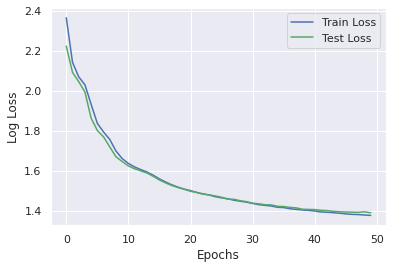

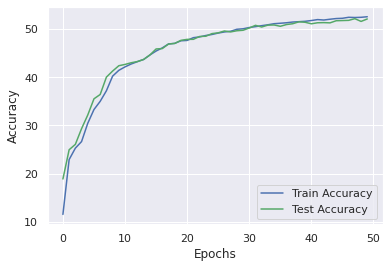

Epoch[0]:
Iteration[200]: Train Loss: 2.445896   Train Accuracy: 0.103447 
## Epoch[0], Train Loss: 2.326271   &   Train Accuracy: 12.838000
## Epoch[0], Test Loss: 2.146621   &   Test Accuracy: 20.930000
Epoch[1]:
Iteration[200]: Train Loss: 2.131112   Train Accuracy: 0.226837 
## Epoch[1], Train Loss: 2.098483   &   Train Accuracy: 24.100000
## Epoch[1], Test Loss: 2.058892   &   Test Accuracy: 26.570000
Epoch[2]:
Iteration[200]: Train Loss: 2.058632   Train Accuracy: 0.267784 
## Epoch[2], Train Loss: 2.005540   &   Train Accuracy: 27.810000
## Epoch[2], Test Loss: 1.905318   &   Test Accuracy: 31.800000
Epoch[3]:
Iteration[200]: Train Loss: 1.874167   Train Accuracy: 0.324867 
## Epoch[3], Train Loss: 1.829696   &   Train Accuracy: 33.366000
## Epoch[3], Test Loss: 1.789792   &   Test Accuracy: 34.960000
Epoch[4]:
Iteration[200]: Train Loss: 1.777711   Train Accuracy: 0.359532 
## Epoch[4], Train Loss: 1.753943   &   Train Accuracy: 36.508000
## Epoch[4], Test Loss: 1.736888   &   

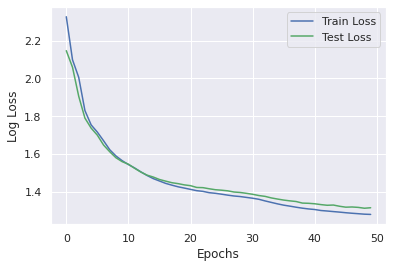

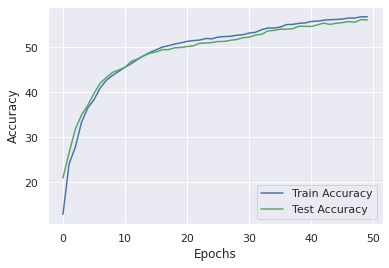

Epoch[0]:
Iteration[200]: Train Loss: 2.505124   Train Accuracy: 0.125824 
## Epoch[0], Train Loss: 2.338855   &   Train Accuracy: 15.488000
## Epoch[0], Test Loss: 2.138934   &   Test Accuracy: 21.920000
Epoch[1]:
Iteration[200]: Train Loss: 2.128945   Train Accuracy: 0.232491 
## Epoch[1], Train Loss: 2.100248   &   Train Accuracy: 23.814000
## Epoch[1], Test Loss: 2.069397   &   Test Accuracy: 25.120000
Epoch[2]:
Iteration[200]: Train Loss: 2.068016   Train Accuracy: 0.253258 
## Epoch[2], Train Loss: 2.050204   &   Train Accuracy: 25.676000
## Epoch[2], Test Loss: 2.034019   &   Test Accuracy: 26.610000
Epoch[3]:
Iteration[200]: Train Loss: 2.037311   Train Accuracy: 0.270925 
## Epoch[3], Train Loss: 2.018336   &   Train Accuracy: 27.040000
## Epoch[3], Test Loss: 2.000057   &   Test Accuracy: 28.260000
Epoch[4]:
Iteration[200]: Train Loss: 1.995722   Train Accuracy: 0.290437 
## Epoch[4], Train Loss: 1.968846   &   Train Accuracy: 30.078000
## Epoch[4], Test Loss: 1.929070   &   

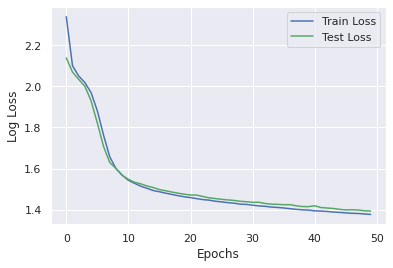

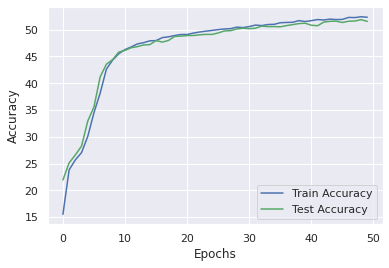

Epoch[0]:
Iteration[200]: Train Loss: 2.424140   Train Accuracy: 0.122213 
## Epoch[0], Train Loss: 2.311201   &   Train Accuracy: 16.464000
## Epoch[0], Test Loss: 2.151930   &   Test Accuracy: 24.880000
Epoch[1]:
Iteration[200]: Train Loss: 2.079792   Train Accuracy: 0.280740 
## Epoch[1], Train Loss: 1.979905   &   Train Accuracy: 30.664000
## Epoch[1], Test Loss: 1.837437   &   Test Accuracy: 35.380000
Epoch[2]:
Iteration[200]: Train Loss: 1.819147   Train Accuracy: 0.364243 
## Epoch[2], Train Loss: 1.786313   &   Train Accuracy: 36.462000
## Epoch[2], Test Loss: 1.748759   &   Test Accuracy: 37.730000
Epoch[3]:
Iteration[200]: Train Loss: 1.743907   Train Accuracy: 0.383480 
## Epoch[3], Train Loss: 1.723157   &   Train Accuracy: 38.466000
## Epoch[3], Test Loss: 1.701955   &   Test Accuracy: 39.400000
Epoch[4]:
Iteration[200]: Train Loss: 1.703120   Train Accuracy: 0.397809 
## Epoch[4], Train Loss: 1.685839   &   Train Accuracy: 39.886000
## Epoch[4], Test Loss: 1.668914   &   

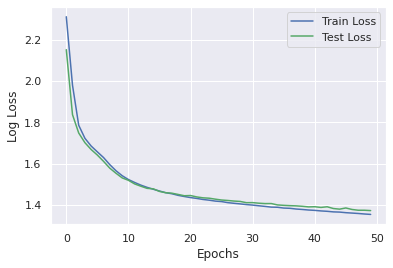

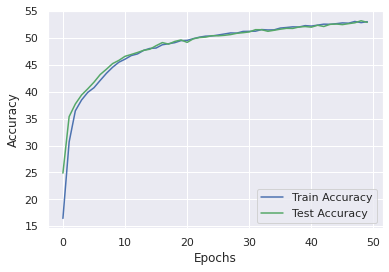

Epoch[0]:
Iteration[200]: Train Loss: 2.359929   Train Accuracy: 0.163120 
## Epoch[0], Train Loss: 2.249507   &   Train Accuracy: 19.382000
## Epoch[0], Test Loss: 2.115553   &   Test Accuracy: 24.590000
Epoch[1]:
Iteration[200]: Train Loss: 2.099555   Train Accuracy: 0.255261 
## Epoch[1], Train Loss: 2.022432   &   Train Accuracy: 28.512000
## Epoch[1], Test Loss: 1.852817   &   Test Accuracy: 35.520000
Epoch[2]:
Iteration[200]: Train Loss: 1.818853   Train Accuracy: 0.358315 
## Epoch[2], Train Loss: 1.782859   &   Train Accuracy: 36.848000
## Epoch[2], Test Loss: 1.731256   &   Test Accuracy: 39.560000
Epoch[3]:
Iteration[200]: Train Loss: 1.733545   Train Accuracy: 0.388387 
## Epoch[3], Train Loss: 1.710464   &   Train Accuracy: 39.400000
## Epoch[3], Test Loss: 1.688384   &   Test Accuracy: 41.090000
Epoch[4]:
Iteration[200]: Train Loss: 1.696121   Train Accuracy: 0.406878 
## Epoch[4], Train Loss: 1.673850   &   Train Accuracy: 41.230000
## Epoch[4], Test Loss: 1.658245   &   

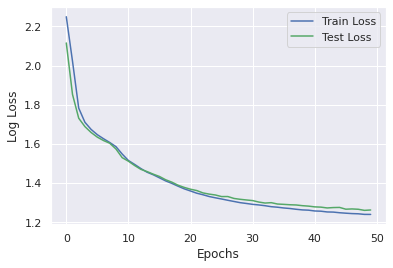

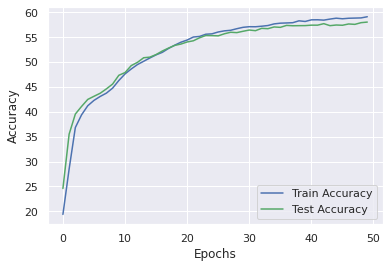

In [26]:
MODEL_NO = 1
net_ensemble = []
for num_ensembles in range(total_ensembles):
  # Initilaize the model, criterion and optimizer
  model = SimpleConvNet(input_channels=input_channels, dims=dims)

  model.layer1[0].weight = nn.Parameter((torch.rand(((model.layer1[0].weight.shape))) - 0.5)/2)
  model.layer2[0].weight = nn.Parameter((torch.rand(((model.layer2[0].weight.shape))) - 0.5)/2)
  model.fc.weight = nn.Parameter((torch.rand(((model.fc.weight.shape))) - 0.5)/2)

  if use_cuda:
    model = model.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = VOGN(model, train_set_size=N, lr=5e-4, prior_prec=1e2, initial_prec=1e2, num_samples=10)
  #optimizer = optim.Adam(model.parameters())
  model, train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, [trainloader, testloader], criterion,
                                                                          optimizer, num_epochs=50)
  MODEL_NO += 1

  net_ensemble.append(model)

  # Plot the results
  fig, ax = plt.subplots()
  ax.plot(train_loss, 'b')
  ax.plot(test_loss, 'g')
  ax.legend(["Train Loss", "Test Loss"])
  plt.ylabel("Log Loss")
  plt.xlabel("Epochs")
  plt.show()

  fig, ax = plt.subplots()
  ax.plot(train_accuracy, 'b')
  ax.plot(test_accuracy, 'g')
  ax.legend(["Train Accuracy", "Test Accuracy"])
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.show()

## Ensemble

In [37]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 128

TRAIN_SIZE = len(trainloader.dataset)
TEST_SIZE = len(testloader.dataset)
print(TRAIN_SIZE)
print(TEST_SIZE)
NUM_BATCHES = len(trainloader)
NUM_TEST_BATCHES = len(testloader)

CLASSES = 10
TRAIN_EPOCHS = 50
TEST_SAMPLES = 2

50000
10000


In [38]:
for num_ensembles in range (total_ensembles):
  for epoch in range(TRAIN_EPOCHS):
    model_save_name = 'VOGN_model{}_epoch{}'.format(num_ensembles + 1,epoch)    
    path = "/content/gdrive/My Drive/CS7643ModelsTesting/CIFAR10Models/{}".format(model_save_name) 
    checkpoint = torch.load(path)
    net_ensemble[num_ensembles].load_state_dict(checkpoint)

# for i in range(len(net_ensemble)):
#   model_save_name = 'BBB_model{}_epoch{}'.format(i+1,)    
#   path = "/content/gdrive/My Drive/testing_bbb/SavedModels/{}".format(model_save_name) 
#   checkpoint = torch.load(path)
#   net_ensemble[i].load_state_dict(checkpoint)


In [39]:
def prediction_BBB(data,net):
    net.eval()
    with torch.no_grad():
        data= data.to(DEVICE)
        outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
        for i in range(TEST_SAMPLES):
            # print("1: ", outputs[i].shape)
            temp = torch.exp(net(data))
            # print("2: ", temp.shape)
            outputs[i] = temp    #11*5*10    11 predictions of 5 images with 10 classes
        outputs[TEST_SAMPLES] = torch.exp(net(data))
        output = outputs.mean(0)      #5*10       mean of 11 predictions for each of the 5 image with 10 classes     
    return output

def prediction_deep_BBB(image, net_ensemble):
    probs = 0
    for net in net_ensemble:
        probs += prediction_BBB(image,net)
    mean =probs/len(net_ensemble)
    return mean      

In [40]:
test_loss_BBB, accuracy_BBB = 0, 0
accuracy_BBB2 = 0
accuracy_BBB3 = 0
accuracy_BBB4 = 0
accuracy_BBB5 = 0

test_loss_deep_BBB, accuracy_deep_BBB = 0, 0
criterion = nn.NLLLoss()
count = 0
for images, labels in testloader:
  count += 1
  if count < len(testloader):
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)

    for net in net_ensemble:
      net.train()       

    log_ps_BBB = torch.log(prediction_BBB(images,net_ensemble[0]))
    test_loss_BBB += criterion(log_ps_BBB, labels)
    ps = torch.exp(log_ps_BBB)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_BBB += torch.mean(equals.type(torch.FloatTensor))

    log_ps_BBB = torch.log(prediction_BBB(images,net_ensemble[1]))
    test_loss_BBB += criterion(log_ps_BBB, labels)
    ps = torch.exp(log_ps_BBB)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_BBB2 += torch.mean(equals.type(torch.FloatTensor))

    log_ps_BBB = torch.log(prediction_BBB(images,net_ensemble[2]))
    test_loss_BBB += criterion(log_ps_BBB, labels)
    ps = torch.exp(log_ps_BBB)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_BBB3 += torch.mean(equals.type(torch.FloatTensor))

    log_ps_BBB = torch.log(prediction_BBB(images,net_ensemble[3]))
    test_loss_BBB += criterion(log_ps_BBB, labels)
    ps = torch.exp(log_ps_BBB)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_BBB4 += torch.mean(equals.type(torch.FloatTensor))

    log_ps_BBB = torch.log(prediction_BBB(images,net_ensemble[4]))
    test_loss_BBB += criterion(log_ps_BBB, labels)
    ps = torch.exp(log_ps_BBB)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_BBB5 += torch.mean(equals.type(torch.FloatTensor))


    log_ps_deepBBB = torch.log(prediction_deep_BBB(images,net_ensemble))
    test_loss_deep_BBB += criterion(log_ps_deepBBB, labels)
    ps = torch.exp(log_ps_deepBBB)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy_deep_BBB += torch.mean(equals.type(torch.FloatTensor))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
bbb_acc = accuracy_BBB/len(testloader)
deep_bbb_acc = accuracy_deep_BBB/len(testloader)

print(bbb_acc)
print(accuracy_BBB2/len(testloader))
print(accuracy_BBB3/len(testloader))
print(accuracy_BBB4/len(testloader))
print(accuracy_BBB5/len(testloader))
print()
print()
print(deep_bbb_acc)

tensor(0.5142)
tensor(0.5514)
tensor(0.5096)
tensor(0.5209)
tensor(0.5707)


tensor(0.5887)
